# `evosax`: JAX-Based Evolution Strategies
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: November 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/getting_started.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## The Ask-Eval-Tell API

In [2]:
import jax
import jax.numpy as jnp
from evosax import Simple_ES
from evosax.problems import batch_rosenbrock

rng = jax.random.PRNGKey(0)
strategy = Simple_ES(num_dims=2, popsize=8)
es_params = strategy.default_params
state = strategy.initialize(rng, es_params)

Given our initialized strategy we are now ready to `ask` for a set of candidate parameters. Afterwards, we evaluate these on the 2D Rosenbrock problem and `tell` them to our strategy. The strategy will update its `state` and we can iterate.

In [3]:
x, state = strategy.ask(rng, state, es_params)
fitness = batch_rosenbrock(x, 1, 100)
state = strategy.tell(x, fitness, state, es_params)

## Running the ES Loop with Logging

In [4]:
from evosax.utils import ESLog
es_logging = ESLog(num_dims=2, num_generations=100, top_k=3)

(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Rosenbrock Simple ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

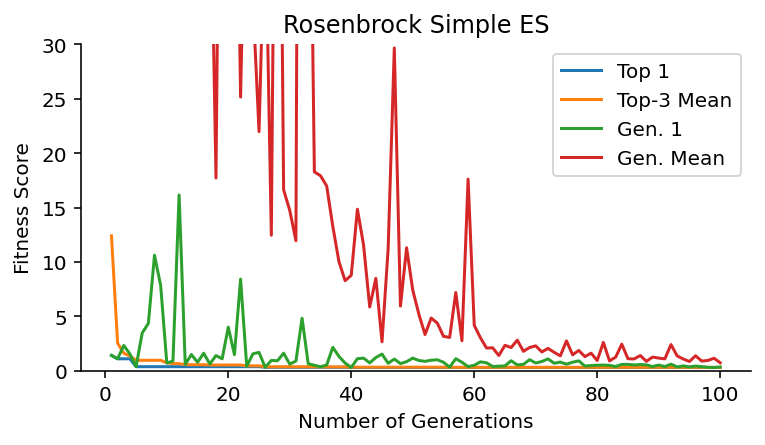

In [5]:
log = es_logging.initialize()
state = strategy.initialize(rng, es_params)
for i in range(100):
    rng, rng_ask = jax.random.split(rng)
    x, state = strategy.ask(rng_ask, state, es_params)
    fitness = batch_rosenbrock(x, 1, 100)
    state = strategy.tell(x, fitness, state, es_params)
    log = es_logging.update(log, x, fitness)
    
es_logging.plot(log, "Rosenbrock Simple ES", ylims=(0, 30))

## Differential Evolution on `gymnax` Pendulum Task

In [6]:
from flax import linen as nn


class MLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return x
    

network = MLP(48, 1, 1)
policy_params = network.init(rng, jnp.zeros(3))["params"]

In [7]:
from evosax.utils import ParameterReshaper

shaper = ParameterReshaper(policy_params)
# Dictinory to vectorize rollouts with
shaper.vmap_dict

{'Dense_0': {'kernel': 0, 'bias': 0}, 'Dense_1': {'kernel': 0, 'bias': 0}}

In [8]:
import gymnax

env, env_params = gymnax.make("Pendulum-v1")


def rollout(rng_input, policy_params, env_params, num_env_steps):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng_reset, rng_episode = jax.random.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)

    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        obs, state, policy_params, rng = state_input
        rng, rng_step = jax.random.split(rng)
        action = network.apply({"params": policy_params}, obs)
        next_o, next_s, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )
        carry = [next_o.squeeze(), next_s, policy_params, rng]
        return carry, [reward, done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [obs, state, policy_params, rng_episode],
      [jnp.zeros((num_env_steps, 2))],
    )
    # Return masked sum of rewards accumulated by agent in episode
    rewards, dones = scan_out[0], scan_out[1]
    rewards = rewards.reshape(num_env_steps, 1)
    ep_mask = (jnp.cumsum(dones) < 1).reshape(num_env_steps, 1)
    return jnp.sum(rewards * ep_mask)


# Jit-Compiled Episode Rollout
jit_rollout = jax.jit(rollout, static_argnums=3)

# Vmap across random keys for Batch Rollout
batch_rollout = jax.vmap(jit_rollout, in_axes=(0, None, None, None))
batch_rng = jax.random.split(rng, 10)
batch_rollout(batch_rng, policy_params, env_params, 200)

DeviceArray([-1565.8835, -1548.2656, -1501.8762, -1339.1084, -1322.4973,
             -1307.5662, -1607.5386, -1597.05  , -1530.2148, -1530.506 ],            dtype=float32)

In [9]:
# Initialize strategy & get first proposal
from evosax import Differential_ES

rng, rng_init, rng_ask = jax.random.split(rng, 3)
strategy = Differential_ES(num_dims=shaper.total_params, popsize=100)
es_params = strategy.default_params
state = strategy.initialize(rng_init, es_params)
x, state = strategy.ask(rng_ask, state, es_params)
x.shape, es_params

((100, 241),
 {'mutate_best_vector': True,
  'num_diff_vectors': 1,
  'crossover_rate': 0.9,
  'diff_w': 0.8,
  'init_min': -2,
  'init_max': 2})

In [10]:
# Reshape parameters into vmapable dict
reshaped_params = shaper.reshape(x)
reshaped_params.keys()

dict_keys(['Dense_0', 'Dense_1'])

In [11]:
# Vmap across parameter dict for Generation Rollout
generation_rollout = jax.vmap(batch_rollout, in_axes=(None, shaper.vmap_dict, None, None), out_axes=0)
gen_returns = generation_rollout(batch_rng, reshaped_params, env_params, 200)
gen_returns.shape, jnp.max(gen_returns.mean(axis=1))

((100, 10), DeviceArray(-1201.183, dtype=float32))

In [12]:
# Update the strategy with the negative mean returns (Note: ES minimizes!)
fitness = - gen_returns.mean(axis=1)
state = strategy.tell(x, fitness, state, es_params)
state["best_fitness"], state["best_member"].shape

(DeviceArray(1201.183, dtype=float32), (241,))

Return:  0 -1026.4646
Return:  20 -201.98573
Return:  40 -147.35631
Return:  60 -147.29448
Return:  80 -147.29448
Return:  100 -147.29448
Return:  120 -147.29448
Return:  140 -132.55913
Return:  160 -117.75391
Return:  180 -117.40299
Return:  200 -117.40299
Return:  220 -117.40299
Return:  240 -117.40299
Return:  260 -117.40299
Return:  280 -117.40299


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Pendulum Differential Evolution'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

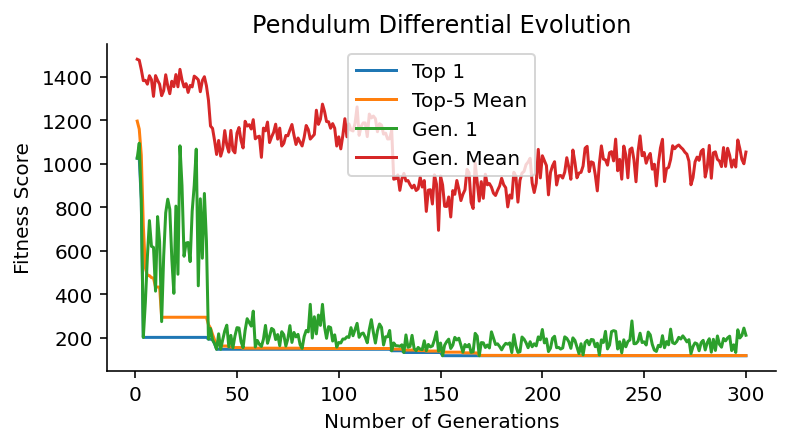

In [13]:
num_generations = 300
print_every_k_gens = 20
state = strategy.initialize(rng_init, es_params)
es_logging = ESLog(shaper.total_params, num_generations, top_k=5)
log = es_logging.initialize()


for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = shaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, 20)
    gen_returns = generation_rollout(batch_rng, reshaped_params, env_params, 200)
    fitness = - gen_returns.mean(axis=1)
    state = strategy.tell(x, fitness, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Return: ", gen, -state["best_fitness"])
        
es_logging.plot(log, "Pendulum Differential Evolution")

## CMA-ES on `brax` Locomotion Task

In [14]:
from brax import envs

In [15]:
# ['ant', 'halfcheetah', 'hopper', 'humanoid', 'reacher', 'walker2d', 'fetch', 'grasp', 'ur5e']
environment = "hopper"  
env = envs.create(env_name=environment)

In [16]:
class TanhMLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return nn.tanh(x)

network = TanhMLP(48, 1, 3)
policy_params = network.init(rng, jnp.zeros(14))["params"]
shaper = ParameterReshaper(policy_params)

In [17]:
def rollout(rng_input, policy_params, num_env_steps):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng, rng_reset = jax.random.split(rng_input)
    state = env.reset(rng_reset)

    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        state, policy_params = state_input
        action = network.apply({"params": policy_params}, state.obs)
        next_s = env.step(state, action)
        carry = [next_s, policy_params]
        return carry, [state.reward, state.done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [state, policy_params],
      [jnp.zeros((num_env_steps, 2))],
    )
    # Return masked sum of rewards accumulated by agent in episode
    rewards, dones = scan_out[0], scan_out[1]
    rewards = rewards.reshape(num_env_steps, 1)
    ep_mask = (jnp.cumsum(dones) < 1).reshape(num_env_steps, 1)
    return jnp.sum(rewards * ep_mask)


# Jit-Compiled Episode Rollout
jit_rollout = jax.jit(rollout, static_argnums=2)

# Vmap across random keys/network vmap dict for Batch Rollout
batch_rollout = jax.vmap(jit_rollout, in_axes=(0, None, None))
generation_rollout = jax.vmap(batch_rollout, in_axes=(None, shaper.vmap_dict, None), out_axes=0)

batch_rng = jax.random.split(rng, 10)
returns = batch_rollout(batch_rng, policy_params, 500)
returns

DeviceArray([12.953162 , 14.494351 , 13.285795 , 12.706526 , 12.746168 ,
             14.529512 , 12.795415 , 13.2593355, 14.533888 , 13.006702 ],            dtype=float32)

Return:  0 107.18733
Return:  50 262.061
Return:  100 292.057
Return:  150 309.79913
Return:  200 342.6112
Return:  250 355.97427
Return:  300 368.8113
Return:  350 390.09506
Return:  400 394.92142
Return:  450 427.78867


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Hopper CMA-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

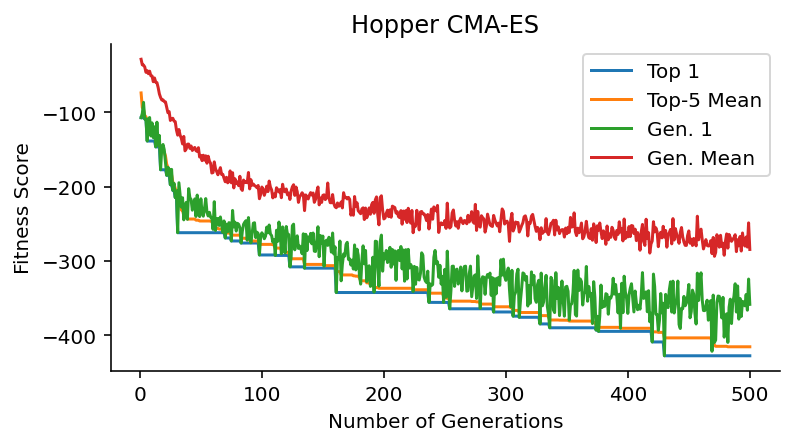

In [18]:
from evosax import CMA_ES

strategy = CMA_ES(num_dims=shaper.total_params, popsize=100)
es_params = strategy.default_params

num_generations = 500
print_every_k_gens = 50
state = strategy.initialize(rng_init, es_params)
es_logging = ESLog(shaper.total_params, num_generations, top_k=5)
log = es_logging.initialize()


for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = shaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, 20)
    gen_returns = generation_rollout(batch_rng, reshaped_params, 500)
    fitness = - gen_returns.mean(axis=1)
    state = strategy.tell(x, fitness, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Return: ", gen, -state["best_fitness"])
        
es_logging.plot(log, "Hopper CMA-ES")